Loaded 50 epochs from /projectnb/ec500kb/projects/Project_1_Team_1/Official_GTP_PANDAS/PANDAS/logs/gat_train_2339664.log

Best Val QWK: 0.8781 at epoch 20
Best Val Acc: 0.8766 at epoch 32
Final Val QWK: 0.8720


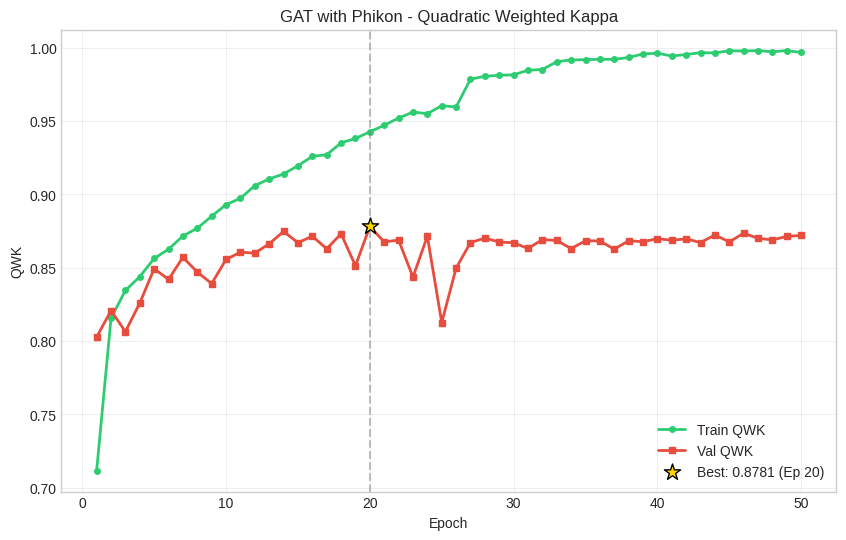

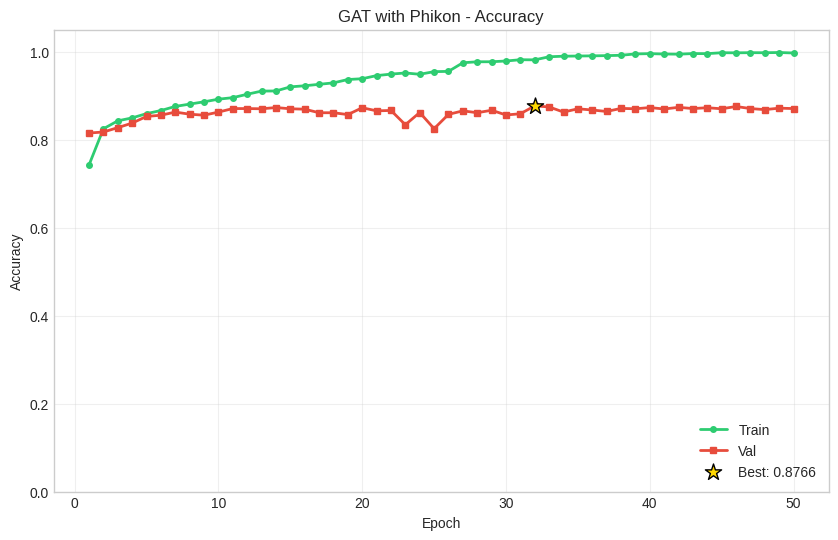

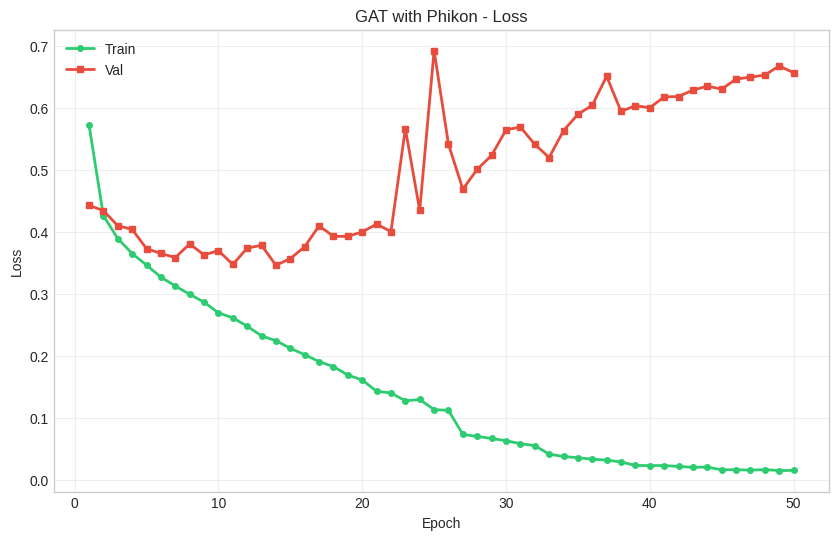

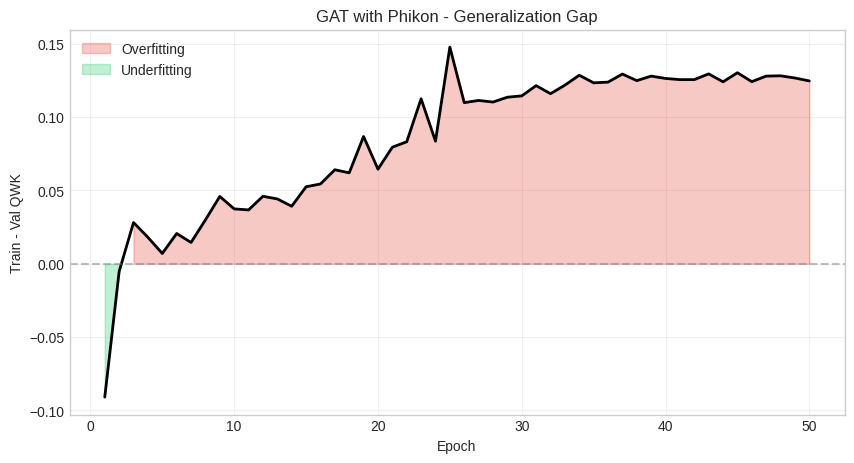

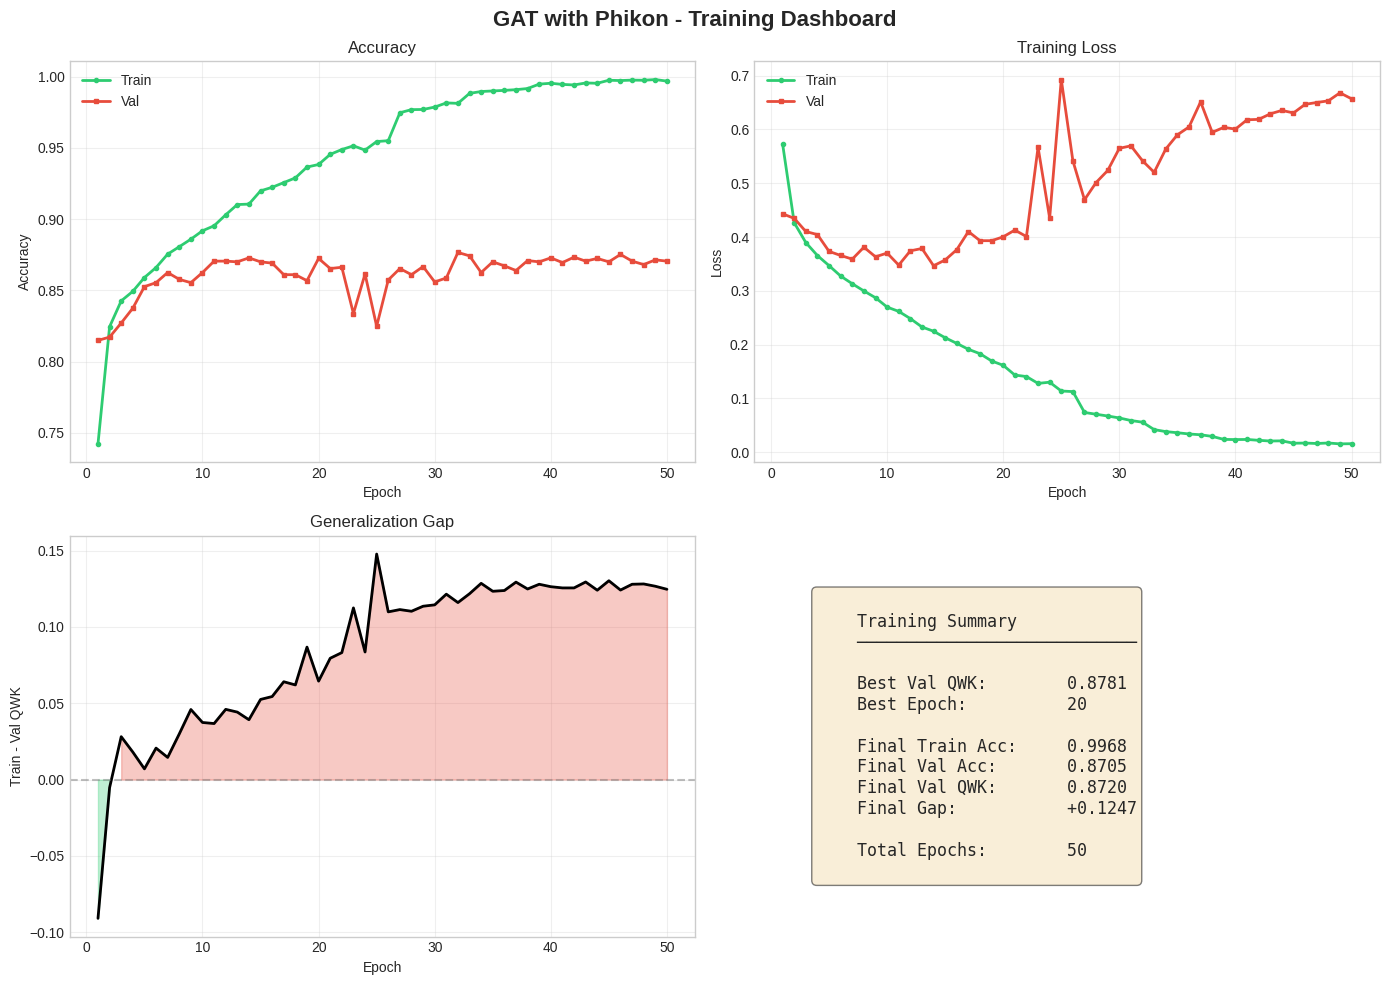

In [4]:
"""
GAT Training Log Parser
=======================
Parses logs in format:
  Epoch X/Y (time)
    Train - Loss: X, Acc: X, QWK: X
    Val   - Loss: X, Acc: X, QWK: X, F1: X
"""

import re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============== CONFIGURATION ==============
LOG_FILE = "/projectnb/ec500kb/projects/Project_1_Team_1/Official_GTP_PANDAS/PANDAS/logs/gat_train_2339664.log"
MODEL_NAME = "GAT with Phikon"
OUTPUT_DIR = "figures"
# ===========================================

def parse_gat_log(filepath):
    """Parse GAT training log and extract metrics."""
    data = {
        'epochs': [],
        'train_loss': [],
        'train_acc': [],
        'train_qwk': [],
        'val_loss': [],
        'val_acc': [],
        'val_qwk': [],
        'val_f1': [],
    }
    
    # Patterns
    epoch_pattern = re.compile(r'Epoch\s+(\d+)/(\d+)')
    train_pattern = re.compile(r'Train\s*-\s*Loss:\s*([\d.]+),\s*Acc:\s*([\d.]+),\s*QWK:\s*([\d.]+)')
    val_pattern = re.compile(r'Val\s*-\s*Loss:\s*([\d.]+),\s*Acc:\s*([\d.]+),\s*QWK:\s*([\d.]+),\s*F1:\s*([\d.]+)')
    
    current_epoch = None
    
    with open(filepath, 'r') as f:
        for line in f:
            # Epoch header
            m = epoch_pattern.search(line)
            if m:
                current_epoch = int(m.group(1))
                continue
            
            # Train metrics
            m = train_pattern.search(line)
            if m and current_epoch:
                data['epochs'].append(current_epoch)
                data['train_loss'].append(float(m.group(1)))
                data['train_acc'].append(float(m.group(2)))
                data['train_qwk'].append(float(m.group(3)))
                continue
            
            # Val metrics
            m = val_pattern.search(line)
            if m:
                data['val_loss'].append(float(m.group(1)))
                data['val_acc'].append(float(m.group(2)))
                data['val_qwk'].append(float(m.group(3)))
                data['val_f1'].append(float(m.group(4)))
    
    # Convert to numpy
    for key in data:
        data[key] = np.array(data[key])
    
    return data

def plot_gat_training(data, model_name="GAT", save_dir=None):
    """Generate training visualization plots for GAT."""
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = {'train': '#2ecc71', 'val': '#e74c3c', 'loss': '#f39c12', 'qwk': '#3498db'}
    
    if save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    # Find best epoch
    best_idx = np.argmax(data['val_qwk'])
    best_epoch = data['epochs'][best_idx]
    best_qwk = data['val_qwk'][best_idx]
    
    # ====== 1. QWK Curves ======
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(data['epochs'], data['train_qwk'], 'o-', color=colors['train'], lw=2, ms=4, label='Train QWK')
    ax.plot(data['epochs'], data['val_qwk'], 's-', color=colors['val'], lw=2, ms=4, label='Val QWK')
    ax.scatter(best_epoch, best_qwk, s=150, c='gold', marker='*', 
               zorder=5, edgecolors='k', label=f"Best: {best_qwk:.4f} (Ep {best_epoch})")
    ax.axvline(best_epoch, color='gray', ls='--', alpha=0.5)
    ax.set(xlabel='Epoch', ylabel='QWK', title=f'{model_name} - Quadratic Weighted Kappa')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    if save_dir: 
        fig.savefig(f"{save_dir}/{model_name.replace(' ', '_')}_qwk.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # ====== 2. Accuracy Curves ======
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(data['epochs'], data['train_acc'], 'o-', color=colors['train'], lw=2, ms=4, label='Train')
    ax.plot(data['epochs'], data['val_acc'], 's-', color=colors['val'], lw=2, ms=4, label='Val')
    best_acc_idx = np.argmax(data['val_acc'])
    ax.scatter(data['epochs'][best_acc_idx], data['val_acc'][best_acc_idx], s=150, c='gold', marker='*', 
               zorder=5, edgecolors='k', label=f"Best: {data['val_acc'][best_acc_idx]:.4f}")
    ax.set(xlabel='Epoch', ylabel='Accuracy', title=f'{model_name} - Accuracy', ylim=[0, 1.05])
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    if save_dir: 
        fig.savefig(f"{save_dir}/{model_name.replace(' ', '_')}_accuracy.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # ====== 3. Loss Curves ======
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(data['epochs'], data['train_loss'], 'o-', color=colors['train'], lw=2, ms=4, label='Train')
    ax.plot(data['epochs'], data['val_loss'], 's-', color=colors['val'], lw=2, ms=4, label='Val')
    ax.set(xlabel='Epoch', ylabel='Loss', title=f'{model_name} - Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    if save_dir: 
        fig.savefig(f"{save_dir}/{model_name.replace(' ', '_')}_loss.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # ====== 4. Generalization Gap ======
    fig, ax = plt.subplots(figsize=(10, 5))
    gap = data['train_qwk'] - data['val_qwk']
    ax.fill_between(data['epochs'], gap, 0, where=(gap > 0), color=colors['val'], alpha=0.3, label='Overfitting')
    ax.fill_between(data['epochs'], gap, 0, where=(gap <= 0), color=colors['train'], alpha=0.3, label='Underfitting')
    ax.plot(data['epochs'], gap, 'k-', lw=2)
    ax.axhline(0, color='gray', ls='--', alpha=0.5)
    ax.set(xlabel='Epoch', ylabel='Train - Val QWK', title=f'{model_name} - Generalization Gap')
    ax.legend()
    ax.grid(True, alpha=0.3)
    if save_dir: 
        fig.savefig(f"{save_dir}/{model_name.replace(' ', '_')}_gap.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # ====== 5. Summary Dashboard ======
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Accuracy
    axes[0,0].plot(data['epochs'], data['train_acc'], 'o-', color=colors['train'], lw=2, ms=3, label='Train')
    axes[0,0].plot(data['epochs'], data['val_acc'], 's-', color=colors['val'], lw=2, ms=3, label='Val')
    axes[0,0].set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Loss
    axes[0,1].plot(data['epochs'], data['train_loss'], 'o-', color=colors['train'], lw=2, ms=3, label='Train')
    axes[0,1].plot(data['epochs'], data['val_loss'], 's-', color=colors['val'], lw=2, ms=3, label='Val')
    axes[0,1].set(xlabel='Epoch', ylabel='Loss', title='Training Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Gap
    axes[1,0].fill_between(data['epochs'], gap, 0, where=(gap > 0), color=colors['val'], alpha=0.3)
    axes[1,0].fill_between(data['epochs'], gap, 0, where=(gap <= 0), color=colors['train'], alpha=0.3)
    axes[1,0].plot(data['epochs'], gap, 'k-', lw=2)
    axes[1,0].axhline(0, color='gray', ls='--', alpha=0.5)
    axes[1,0].set(xlabel='Epoch', ylabel='Train - Val QWK', title='Generalization Gap')
    axes[1,0].grid(True, alpha=0.3)
    
    # Summary text
    axes[1,1].axis('off')
    summary = f"""
    Training Summary
    ────────────────────────────
    
    Best Val QWK:        {best_qwk:.4f}
    Best Epoch:          {best_epoch}
    
    Final Train Acc:     {data['train_acc'][-1]:.4f}
    Final Val Acc:       {data['val_acc'][-1]:.4f}
    Final Val QWK:       {data['val_qwk'][-1]:.4f}
    Final Gap:           {gap[-1]:+.4f}
    
    Total Epochs:        {len(data['epochs'])}
    """
    axes[1,1].text(0.1, 0.5, summary, transform=axes[1,1].transAxes, fontsize=12, 
                   va='center', fontfamily='monospace', 
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    fig.suptitle(f'{model_name} - Training Dashboard', fontsize=16, fontweight='bold')
    plt.tight_layout()
    if save_dir: 
        fig.savefig(f"{save_dir}/{model_name.replace(' ', '_')}_dashboard.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# ============== RUN ==============
if __name__ == "__main__":
    # Parse log
    data = parse_gat_log(LOG_FILE)
    
    print(f"Loaded {len(data['epochs'])} epochs from {LOG_FILE}")
    print(f"\nBest Val QWK: {data['val_qwk'].max():.4f} at epoch {data['epochs'][np.argmax(data['val_qwk'])]}")
    print(f"Best Val Acc: {data['val_acc'].max():.4f} at epoch {data['epochs'][np.argmax(data['val_acc'])]}")
    print(f"Final Val QWK: {data['val_qwk'][-1]:.4f}")
    
    # Plot
    plot_gat_training(data, MODEL_NAME, OUTPUT_DIR)

In [1]:
import random

# Read original validation set
with open('./scripts/val_set.txt', 'r') as f:
    val_ids = [line.strip() for line in f if line.strip()]

print(f"Original val set: {len(val_ids)} WSIs")

# Shuffle with fixed seed for reproducibility
random.seed(42)
random.shuffle(val_ids)

# 80/20 split
split_idx = int(len(val_ids) * 0.8)
new_val = val_ids[:split_idx]
test_set = val_ids[split_idx:]

# Save new splits
with open('./scripts/val_set_new.txt', 'w') as f:
    f.write('\n'.join(new_val))

with open('./scripts/test_set.txt', 'w') as f:
    f.write('\n'.join(test_set))

print(f"New val set: {len(new_val)} WSIs -> ./scripts/val_set_new.txt")
print(f"Test set: {len(test_set)} WSIs -> ./scripts/test_set.txt")

Original val set: 2123 WSIs
New val set: 1698 WSIs -> ./scripts/val_set_new.txt
Test set: 425 WSIs -> ./scripts/test_set.txt
